# Predicting College Football

## Wyatt Rasmussen
## DSC 630

**Imports**

In [1]:
import cfbd
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# configure API key
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'T0SZdudSVeE5E5L1mImh1kShvc0t+1HPCXJQp14x+ii+7YN1HLepgNtbSuVCTjn6'
configuration.api_key_prefix['Authorization'] = 'Bearer'

In [3]:
# create a games API instance
api_config = cfbd.ApiClient(configuration)
games_api = cfbd.GamesApi(cfbd.ApiClient(configuration))

### Building an Elo Based Model

In [4]:
# create a logistic curve function to create rating win expectancy

def get_expected_score(rating, opp_rating):
    exp = (opp_rating - rating) / 300
    return 1 / (1+10**exp)

In [5]:
# creating a get_new_elos function to calculate the elo based on the result

def get_new_elos(home_rating, away_rating, margin):
     
    # score of 0.5 for a tie
    home_score = 0.5
    if margin > 0:
        # score of 1 for a win
        home_score = 1
    elif margin < 0:
        #score of 0 for a loss
        home_score = 0

    # get expected home score
    expected_home_score = get_expected_score(home_rating, away_rating)
    # multiply difference of actual and expected score by k value and adjust home rating
    # removed home_score -
    new_home_score = home_rating + abs(margin) * (home_score - expected_home_score)

    # repeat these steps for the away team
    # away score is inverse of home score
    away_score = 1 - home_score
    expected_away_score = get_expected_score(away_rating, home_rating)
    # removed away_score - expected_away_score
    new_away_score = away_rating + abs(margin) * (away_score - expected_away_score)

    # return a tuple
    return (round(new_home_score), round(new_away_score))

In [6]:
# sorting the games so the elos are determined in chronological order

def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

def elo_sort(team):
    return team['elo']

**2017**
  
Grabbing each season from 2017-2021. This will give me 4 seasons that I can use to train the model that I eventually create and 1 season (2021) to test the model against.

In [7]:
games = []

# was 2013
for year in range(2017, 2018):
    response = games_api.get_games(year=year)
    games = [*games, *response]

In [8]:
games[0]

{'attendance': 37583,
 'away_conference': 'Pac-12',
 'away_id': 204,
 'away_line_scores': [10, 10, 0, 7],
 'away_points': 27,
 'away_post_win_prob': 0.001059250629844466,
 'away_postgame_elo': 1345,
 'away_pregame_elo': 1412,
 'away_team': 'Oregon State',
 'conference_game': False,
 'excitement_index': 4.9529115584,
 'highlights': 'https://www.youtube.com/watch?v=vg6e0rzyt70',
 'home_conference': 'Mountain West',
 'home_id': 36,
 'home_line_scores': [7, 17, 10, 24],
 'home_points': 58,
 'home_post_win_prob': 0.9989407493701555,
 'home_postgame_elo': 1613,
 'home_pregame_elo': 1546,
 'home_team': 'Colorado State',
 'id': 400935282,
 'neutral_site': False,
 'notes': None,
 'season': 2017,
 'season_type': 'regular',
 'start_date': '2017-08-26T18:30:00.000Z',
 'start_time_tbd': None,
 'venue': 'Canvas Stadium',
 'venue_id': 5388,
 'week': 1}

In [9]:
games = [dict(
            game_id = g.id,
            start_date = g.start_date,
            season = g.season,
            home_team = g.home_team,
            home_conference = g.home_conference,
            home_points = g.home_points,
            away_team = g.away_team,
            away_conference = g.away_conference,
            away_points = g.away_points
            ) for g in games if g.home_points is not None and g.away_points is not None]
games.sort(key=date_sort)

In [10]:
games[0]

{'game_id': 400935282,
 'start_date': '2017-08-26T18:30:00.000Z',
 'season': 2017,
 'home_team': 'Colorado State',
 'home_conference': 'Mountain West',
 'home_points': 58,
 'away_team': 'Oregon State',
 'away_conference': 'Pac-12',
 'away_points': 27}

In [11]:
# dict object to hold current Elo rating for each team
teams = dict()

# loop through games in order
for game in games:

    # get current rating for home team
    if game['home_team'] in teams:
        home_elo = teams[game['home_team']]
    # Power 5 get boost
    elif game['home_conference'] is not None:
        # if no rating, but FBS set to 1000
        home_elo = 1000
    else:
        # otherwise, set initial rating to 500 for non-FBS teams
        home_elo = 500

    # get current rating for away team
    if game['away_team'] in teams:
        away_elo = teams[game['away_team']]
    elif game['away_conference'] is not None:
        # if no rating, but FBS set to 1000
        away_elo = 1000
    else:
        # otherwise, set initial rating to 500 for non-FBS teams
        away_elo = 500

    # calculate score margin from game
    margin = game['home_points'] - game['away_points']

    # get new elo ratings
    new_elos = get_new_elos(home_elo, away_elo, margin)

    # set pregame elos on game dict
    game['pregame_home_elo'] = home_elo
    game['pregame_away_elo'] = away_elo

    # set postgame elos on game dict
    game['postgame_home_elo'] = new_elos[0]
    game['postgame_away_elo'] = new_elos[1]

    # set current elo values in teams dict
    teams[game['home_team']] = new_elos[0]
    teams[game['away_team']] = new_elos[1]

In [12]:
end_elos = [dict(team=key, elo=teams[key]) for key in teams]
end_elos.sort(key=elo_sort, reverse=True)

In [13]:
end_elos_df = pd.DataFrame(end_elos).set_index('elo')

In [14]:
end_elos_df.head(25)

,team
elo,
1118,Penn State
1110,Alabama
1109,Ohio State
1107,Oklahoma
1106,Wisconsin
1105,Georgia
1104,Clemson
1096,UCF
1088,Auburn


In [15]:
games_df = pd.DataFrame(games)

In [16]:
games_df.sample(3)

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo
525,400935393,2017-10-28T16:00:00.000Z,2017,Michigan,Big Ten,35,Rutgers,Big Ten,14,1024,971,1032,963
60,400934489,2017-09-02T23:00:00.000Z,2017,Baylor,Big 12,45,Liberty,None,48,1000,500,997,503
672,400938658,2017-11-11T22:00:00.000Z,2017,North Texas,Conference USA,45,UTEP,Conference USA,10,980,904,993,891


In [17]:
games_df['margin'] = games_df['home_points'] - games_df['away_points']

In [18]:
games_df.sample(5)

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin
8,400941787,2017-08-31T23:00:00.000Z,2017,Cincinnati,American Athletic,26,Austin Peay,None,14,1000,500,1000,500,12
68,400934491,2017-09-02T23:10:00.000Z,2017,Kansas State,Big 12,55,Central Arkansas,None,19,1000,500,1001,499,36
261,400934515,2017-09-23T22:30:00.000Z,2017,Baylor,Big 12,41,Oklahoma,Big 12,49,988,1050,985,1053,-8
808,400935327,2017-11-26T00:00:00.000Z,2017,Oregon,Pac-12,69,Oregon State,Pac-12,10,1001,914,1021,894,59
244,400933869,2017-09-23T19:30:00.000Z,2017,South Carolina,SEC,17,Louisiana Tech,Conference USA,16,1008,984,1008,984,1


In [19]:
games_df.tail()

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin
829,400944885,2017-12-03T00:30:00.000Z,2017,Arkansas State,Sun Belt,25,Troy,Sun Belt,32,1045,1042,1041,1046,-7
830,400955154,2017-12-03T00:45:00.000Z,2017,Boise State,Mountain West,17,Fresno State,Mountain West,14,1050,1030,1051,1029,3
831,400955155,2017-12-03T01:00:00.000Z,2017,Clemson,ACC,38,Miami,ACC,3,1088,1062,1104,1046,35
832,400955156,2017-12-03T01:00:00.000Z,2017,Wisconsin,Big Ten,21,Ohio State,Big Ten,27,1109,1106,1106,1109,-6
833,400934572,2017-12-09T20:00:00.000Z,2017,Navy,American Athletic,13,Army,FBS Independents,14,1007,1018,1007,1018,-1


In [20]:
games_df.dtypes

game_id               int64
start_date           object
season                int64
home_team            object
home_conference      object
home_points           int64
away_team            object
away_conference      object
away_points           int64
pregame_home_elo      int64
pregame_away_elo      int64
postgame_home_elo     int64
postgame_away_elo     int64
margin                int64
dtype: object

In [21]:
games2017 = games_df.loc[games_df['season'] == 2017]

In [22]:
games2017.head()

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin
0,400935282,2017-08-26T18:30:00.000Z,2017,Colorado State,Mountain West,58,Oregon State,Pac-12,27,1000,1000,1016,984,31
1,400945031,2017-08-26T19:00:00.000Z,2017,BYU,FBS Independents,20,Portland State,None,6,1000,500,1000,500,14
2,400938887,2017-08-26T22:00:00.000Z,2017,UMass,FBS Independents,35,Hawai'i,Mountain West,38,1000,1000,998,1002,-3
3,400941786,2017-08-26T23:30:00.000Z,2017,San José State,Mountain West,22,South Florida,American Athletic,42,1000,1000,990,1010,-20
4,400935257,2017-08-27T02:00:00.000Z,2017,Rice,Conference USA,7,Stanford,Pac-12,62,1000,1000,972,1028,-55


**2018**

In [23]:
games1 = []

# was 2014
for year in range(2018, 2019):
    response = games_api.get_games(year=year)
    games1 = [*games1, *response]

In [24]:
games1[0]

{'attendance': 8684,
 'away_conference': None,
 'away_id': 2184,
 'away_line_scores': [3, 6, 0, 6],
 'away_points': 15,
 'away_post_win_prob': 0.001545757783768864,
 'away_postgame_elo': None,
 'away_pregame_elo': None,
 'away_team': 'Duquesne',
 'conference_game': False,
 'excitement_index': 0.2139101303,
 'highlights': 'https://www.youtube.com/watch?v=uwMMvX-tU_U',
 'home_conference': 'FBS Independents',
 'home_id': 113,
 'home_line_scores': [21, 14, 21, 7],
 'home_points': 63,
 'home_post_win_prob': 0.9984542422162311,
 'home_postgame_elo': None,
 'home_pregame_elo': None,
 'home_team': 'UMass',
 'id': 401013357,
 'neutral_site': False,
 'notes': None,
 'season': 2018,
 'season_type': 'regular',
 'start_date': '2018-08-25T21:30:00.000Z',
 'start_time_tbd': None,
 'venue': 'Warren McGuirk Alumni Stadium',
 'venue_id': 3985,
 'week': 1}

In [25]:
games1 = [dict(
            game_id = g.id,
            start_date = g.start_date,
            season = g.season,
            home_team = g.home_team,
            home_conference = g.home_conference,
            home_points = g.home_points,
            away_team = g.away_team,
            away_conference = g.away_conference,
            away_points = g.away_points
            ) for g in games1 if g.home_points is not None and g.away_points is not None]
games1.sort(key=date_sort)

In [26]:
games1[0]

{'game_id': 401013357,
 'start_date': '2018-08-25T21:30:00.000Z',
 'season': 2018,
 'home_team': 'UMass',
 'home_conference': 'FBS Independents',
 'home_points': 63,
 'away_team': 'Duquesne',
 'away_conference': None,
 'away_points': 15}

In [27]:
# dict object to hold current Elo rating for each team
teams1 = dict()

# loop through games in order
for game in games1:

    # get current rating for home team
    if game['home_team'] in teams1:
        home_elo = teams1[game['home_team']]
    # Power 5 get boost
    elif game['home_conference'] is not None:
        # if no rating, but FBS set to 1000
        home_elo = 1000
    else:
        # otherwise, set initial rating to 500 for non-FBS teams
        home_elo = 500

    # get current rating for away team
    if game['away_team'] in teams1:
        away_elo = teams1[game['away_team']]
    elif game['away_conference'] is not None:
        # if no rating, but FBS set to 1000
        away_elo = 1000
    else:
        # otherwise, set initial rating to 500 for non-FBS teams
        away_elo = 500
        
        
    # calculate score margin from game
    margin = game['home_points'] - game['away_points']

    # get new elo ratings
    new_elos = get_new_elos(home_elo, away_elo, margin)

    # set pregame elos on game dict
    game['pregame_home_elo'] = home_elo
    game['pregame_away_elo'] = away_elo

    # set postgame elos on game dict
    game['postgame_home_elo'] = new_elos[0]
    game['postgame_away_elo'] = new_elos[1]

    # set current elo values in teams dict
    teams1[game['home_team']] = new_elos[0]
    teams1[game['away_team']] = new_elos[1]

In [28]:
end_elos1 = [dict(team=key, elo=teams1[key]) for key in teams1]
end_elos1.sort(key=elo_sort, reverse=True)

In [29]:
end_elos_df1 = pd.DataFrame(end_elos1).set_index('elo')

In [30]:
end_elos_df1.head(25)

,team
elo,
1150,Alabama
1136,Clemson
1097,UCF
1097,Ohio State
1094,Oklahoma
1091,Georgia
1091,Michigan
1086,Notre Dame
1084,Utah State


In [31]:
games1_df = pd.DataFrame(games1)

In [32]:
games1_df['margin'] = games1_df['home_points'] - games1_df['away_points']

In [33]:
games2018 = games1_df.loc[games1_df['season'] == 2018]

In [34]:
games2018.head()

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin
0,401013357,2018-08-25T21:30:00.000Z,2018,UMass,FBS Independents,63,Duquesne,None,15,1000,500,1001,499,48
1,401014972,2018-08-25T23:00:00.000Z,2018,Rice,Conference USA,31,Prairie View,None,28,1000,500,1000,500,3
2,401022510,2018-08-25T23:30:00.000Z,2018,Colorado State,Mountain West,34,Hawai'i,Mountain West,43,1000,1000,996,1004,-9
3,401013437,2018-08-26T02:00:00.000Z,2018,New Mexico State,FBS Independents,7,Wyoming,Mountain West,29,1000,1000,989,1011,-22
4,401019470,2018-08-30T23:00:00.000Z,2018,Connecticut,American Athletic,17,UCF,American Athletic,56,1000,1000,980,1020,-39


**2019**

In [35]:
games2 = []

# was 2015
for year in range(2019, 2020):
    response = games_api.get_games(year=year)
    games2 = [*games2, *response]

In [36]:
games2[0]

{'attendance': 66543,
 'away_conference': 'ACC',
 'away_id': 2390,
 'away_line_scores': [3, 10, 0, 7],
 'away_points': 20,
 'away_post_win_prob': 0.09404654178677352,
 'away_postgame_elo': 1606,
 'away_pregame_elo': 1611,
 'away_team': 'Miami',
 'conference_game': False,
 'excitement_index': 8.7679102419,
 'highlights': 'https://www.youtube.com/watch?v=WeJi4p0jqXA',
 'home_conference': 'SEC',
 'home_id': 57,
 'home_line_scores': [7, 0, 10, 7],
 'home_points': 24,
 'home_post_win_prob': 0.9059534582132265,
 'home_postgame_elo': 1688,
 'home_pregame_elo': 1683,
 'home_team': 'Florida',
 'id': 401110723,
 'neutral_site': True,
 'notes': 'CAMPING WORLD KICKOFF',
 'season': 2019,
 'season_type': 'regular',
 'start_date': '2019-08-24T23:00:00.000Z',
 'start_time_tbd': None,
 'venue': 'Camping World Stadium',
 'venue_id': 4013,
 'week': 1}

In [37]:
games2 = [dict(
            game_id = g.id,
            start_date = g.start_date,
            season = g.season,
            home_team = g.home_team,
            home_conference = g.home_conference,
            home_points = g.home_points,
            away_team = g.away_team,
            away_conference = g.away_conference,
            away_points = g.away_points
            ) for g in games2 if g.home_points is not None and g.away_points is not None]
games2.sort(key=date_sort)

In [38]:
# dict object to hold current Elo rating for each team
teams2 = dict()

# loop through games in order
for game in games2:

    
    # get current rating for home team
    if game['home_team'] in teams2:
        home_elo = teams2[game['home_team']]
    # Power 5 get boost
    elif game['home_conference'] is not None:
        # if no rating, but FBS set to 1000
        home_elo = 1000
    else:
        # otherwise, set initial rating to 500 for non-FBS teams
        home_elo = 500

    # get current rating for away team
    if game['away_team'] in teams2:
        away_elo = teams2[game['away_team']]
    elif game['away_conference'] is not None:
        # if no rating, but FBS set to 1000
        away_elo = 1000
    else:
        # otherwise, set initial rating to 500 for non-FBS teams
        away_elo = 500

    # calculate score margin from game
    margin = game['home_points'] - game['away_points']

    # get new elo ratings
    new_elos = get_new_elos(home_elo, away_elo, margin)

    # set pregame elos on game dict
    game['pregame_home_elo'] = home_elo
    game['pregame_away_elo'] = away_elo

    # set postgame elos on game dict
    game['postgame_home_elo'] = new_elos[0]
    game['postgame_away_elo'] = new_elos[1]

    # set current elo values in teams dict
    teams2[game['home_team']] = new_elos[0]
    teams2[game['away_team']] = new_elos[1]

In [39]:
end_elos2 = [dict(team=key, elo=teams2[key]) for key in teams2]
end_elos2.sort(key=elo_sort, reverse=True)

In [40]:
end_elos_df2 = pd.DataFrame(end_elos2).set_index('elo')

In [41]:
end_elos_df2.head(25)

,team
elo,
1169,Ohio State
1154,Clemson
1123,LSU
1109,Alabama
1102,Oregon
1098,Wisconsin
1092,Utah
1086,Notre Dame
1084,Appalachian State


In [42]:
games2_df = pd.DataFrame(games2)

In [43]:
games2_df['margin'] = games2_df['home_points'] - games2_df['away_points']

In [44]:
games2019 = games2_df.loc[games2_df['season'] == 2019]

In [45]:
games2019.head()

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin
0,401110723,2019-08-24T23:00:00.000Z,2019,Florida,SEC,24,Miami,ACC,20,1000,1000,1002,998,4
1,401114164,2019-08-25T02:30:00.000Z,2019,Hawai'i,Mountain West,45,Arizona,Pac-12,38,1000,1000,1004,996,7
2,401119254,2019-08-29T23:00:00.000Z,2019,Bowling Green,Mid-American,46,Morgan State,None,3,1000,500,1001,499,43
3,401117855,2019-08-29T23:00:00.000Z,2019,Connecticut,American Athletic,24,Wagner,None,21,1000,500,1000,500,3
4,401119255,2019-08-29T23:00:00.000Z,2019,Buffalo,Mid-American,38,Robert Morris,None,10,1000,500,1001,499,28


**2020**

In [46]:
games3 = []

#was 2016
for year in range(2020, 2021):
    response = games_api.get_games(year=year)
    games3 = [*games3, *response]

In [47]:
games3 = [dict(
            game_id = g.id,
            start_date = g.start_date,
            season = g.season,
            home_team = g.home_team,
            home_conference = g.home_conference,
            home_points = g.home_points,
            away_team = g.away_team,
            away_conference = g.away_conference,
            away_points = g.away_points
            ) for g in games3 if g.home_points is not None and g.away_points is not None]
games3.sort(key=date_sort)

In [48]:
# dict object to hold current Elo rating for each team
teams3 = dict()

# loop through games in order
for game in games3:

    # get current rating for home team
    if game['home_team'] in teams3:
        home_elo = teams3[game['home_team']]
    # Power 5 get boost
    elif game['home_conference'] is not None:
        # if no rating, but FBS set to 1000
        home_elo = 1000
    else:
        # otherwise, set initial rating to 500 for non-FBS teams
        home_elo = 500

    # get current rating for away team
    if game['away_team'] in teams3:
        away_elo = teams3[game['away_team']]
    elif game['away_conference'] is not None:
        # if no rating, but FBS set to 1000
        away_elo = 1000
    else:
        # otherwise, set initial rating to 500 for non-FBS teams
        away_elo = 500

    # calculate score margin from game
    margin = game['home_points'] - game['away_points']

    # get new elo ratings
    new_elos = get_new_elos(home_elo, away_elo, margin)

    # set pregame elos on game dict
    game['pregame_home_elo'] = home_elo
    game['pregame_away_elo'] = away_elo

    # set postgame elos on game dict
    game['postgame_home_elo'] = new_elos[0]
    game['postgame_away_elo'] = new_elos[1]

    # set current elo values in teams dict
    teams3[game['home_team']] = new_elos[0]
    teams3[game['away_team']] = new_elos[1]

In [49]:
end_elos3 = [dict(team=key, elo=teams3[key]) for key in teams3]
end_elos3.sort(key=elo_sort, reverse=True)

In [50]:
end_elos_df3 = pd.DataFrame(end_elos3).set_index('elo')

In [51]:
end_elos_df3.head(25)

,team
elo,
1129,Alabama
1107,Clemson
1106,BYU
1080,Coastal Carolina
1077,Cincinnati
1073,Notre Dame
1063,Oklahoma
1060,Florida
1060,Buffalo


In [52]:
games3_df = pd.DataFrame(games3)

In [53]:
games3_df['margin'] = games3_df['home_points'] - games3_df['away_points']

In [54]:
games2020 = games3_df.loc[games3_df['season'] == 2020]

In [55]:
games2020.sample(5)

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin
138,401234606,2020-10-10T23:30:00.000Z,2020,Notre Dame,FBS Independents,42,Florida State,ACC,26,1032,978,1038,972,16
540,401237074,2020-12-20T01:00:00.000Z,2020,Florida,SEC,46,Alabama,SEC,52,1062,1127,1060,1129,-6
82,401237096,2020-10-03T16:00:00.000Z,2020,Florida,SEC,38,South Carolina,SEC,24,1008,998,1015,991,14
296,401207169,2020-11-07T23:00:00.000Z,2020,Florida Atlantic,Conference USA,10,Western Kentucky,Conference USA,6,1007,961,1009,959,4
312,401249864,2020-11-12T01:00:00.000Z,2020,Northern Illinois,Mid-American,10,Central Michigan,Mid-American,40,990,1002,976,1016,-30


**2021**

In [56]:
games4 = []

# was 2017
for year in range(2021, 2022):
    response = games_api.get_games(year=year)
    games4 = [*games4, *response]

In [57]:
games4 = [dict(
            game_id = g.id,
            start_date = g.start_date,
            season = g.season,
            home_team = g.home_team,
            home_conference = g.home_conference,
            home_points = g.home_points,
            away_team = g.away_team,
            away_conference = g.away_conference,
            away_points = g.away_points
            ) for g in games4 if g.home_points is not None and g.away_points is not None]
games4.sort(key=date_sort)

In [58]:
# dict object to hold current Elo rating for each team
teams4 = dict()

# loop through games in order
for game in games4:

    # get current rating for home team
    if game['home_team'] in teams4:
        home_elo = teams4[game['home_team']]
    # Power 5 get boost
    elif game['home_conference'] is not None:
        # if no rating, but FBS set to 1000
        home_elo = 1000
    else:
        # otherwise, set initial rating to 500 for non-FBS teams
        home_elo = 500

    # get current rating for away team
    if game['away_team'] in teams4:
        away_elo = teams4[game['away_team']]
    elif game['away_conference'] is not None:
        # if no rating, but FBS set to 1000
        away_elo = 1000
    else:
        # otherwise, set initial rating to 500 for non-FBS teams
        away_elo = 500

    # calculate score margin from game
    margin = game['home_points'] - game['away_points']

    # get new elo ratings
    new_elos = get_new_elos(home_elo, away_elo, margin)

    # set pregame elos on game dict
    game['pregame_home_elo'] = home_elo
    game['pregame_away_elo'] = away_elo

    # set postgame elos on game dict
    game['postgame_home_elo'] = new_elos[0]
    game['postgame_away_elo'] = new_elos[1]

    # set current elo values in teams dict
    teams4[game['home_team']] = new_elos[0]
    teams4[game['away_team']] = new_elos[1]

In [59]:
end_elos4 = [dict(team=key, elo=teams4[key]) for key in teams4]
end_elos4.sort(key=elo_sort, reverse=True)

In [60]:
end_elos_df4 = pd.DataFrame(end_elos4).set_index('elo')

In [61]:
end_elos_df4.head(25)

,team
elo,
1125,Georgia
1114,Ohio State
1112,Michigan
1109,Cincinnati
1106,Alabama
1083,Notre Dame
1081,Pittsburgh
1079,Coastal Carolina
1078,Utah


In [62]:
games4_df = pd.DataFrame(games4)

In [63]:
games4_df['margin'] = games4_df['home_points'] - games4_df['away_points']

In [64]:
games2021 = games4_df.loc[games4_df['season'] == 2021]

In [65]:
games2021.head()

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin
0,401282714,2021-08-28T17:20:00.000Z,2021,Illinois,Big Ten,30,Nebraska,Big Ten,22,1000,1000,1004,996,8
1,401286187,2021-08-28T18:00:00.000Z,2021,Fresno State,Mountain West,45,Connecticut,American Athletic,0,1000,1000,1022,978,45
2,401309833,2021-08-28T19:30:00.000Z,2021,UCLA,Pac-12,44,Hawai'i,Mountain West,10,1000,1000,1017,983,34
3,401282049,2021-08-29T01:30:00.000Z,2021,New Mexico State,FBS Independents,3,UTEP,Conference USA,30,1000,1000,986,1014,-27
4,401310693,2021-08-29T02:00:00.000Z,2021,San José State,Mountain West,45,Southern Utah,None,14,1000,500,1001,499,31


**Building a Model to Predict Results**
  
Building this model to run through games, based on the pre game elo rating will learn the post game margin in order to begin to predict games in the future.

Concatenating 2017-2020 retroactively to create a test group of data.

In [66]:
games2017_2020 = pd.concat([games2017, games2018, games2019, games2020])

In [67]:
games2017_2020.shape

(3069, 14)

Over 3000 different games to use should be plenty to train the model I build.

In [68]:
import matplotlib.pyplot as plt

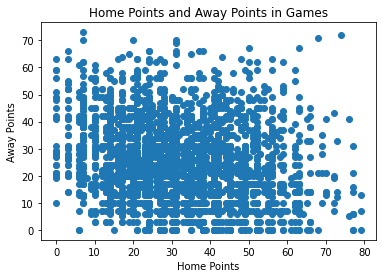

In [69]:
plt.scatter(x=games2017_2020['home_points'], y=games2017_2020['away_points'])
plt.xlabel('Home Points')
plt.ylabel('Away Points')
plt.title('Home Points and Away Points in Games')
plt.show()

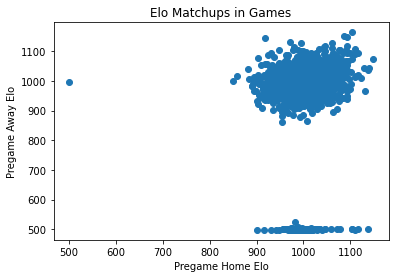

In [70]:
plt.scatter(x=games2017_2020['pregame_home_elo'], y=games2017_2020['pregame_away_elo'])
plt.xlabel('Pregame Home Elo')
plt.ylabel('Pregame Away Elo')
plt.title('Elo Matchups in Games')
plt.show()

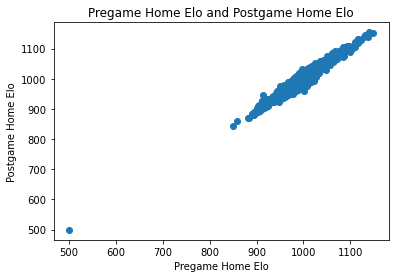

In [71]:
plt.scatter(x=games2017_2020['pregame_home_elo'], y=games2017_2020['postgame_home_elo'])
plt.xlabel('Pregame Home Elo')
plt.ylabel('Postgame Home Elo')
plt.title('Pregame Home Elo and Postgame Home Elo')
plt.show()

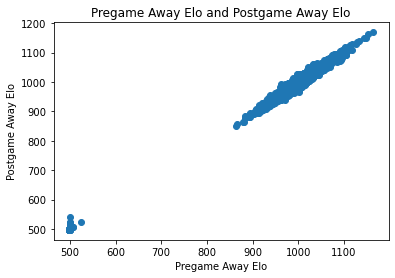

In [72]:
plt.scatter(x=games2017_2020['pregame_away_elo'], y=games2017_2020['postgame_away_elo'])
plt.xlabel('Pregame Away Elo')
plt.ylabel('Postgame Away Elo')
plt.title('Pregame Away Elo and Postgame Away Elo')
plt.show()

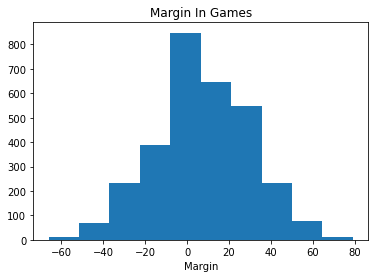

In [73]:
plt.hist(games2017_2020['margin'])
plt.xlabel('Margin')
plt.title('Margin In Games')
plt.show()

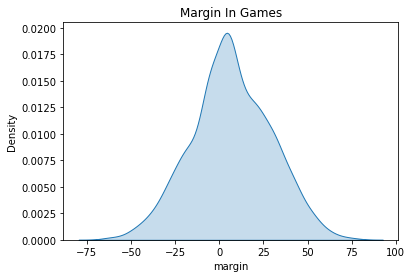

In [74]:
sns.kdeplot(games2017_2020['margin'], shade=True)
plt.title('Margin In Games')
plt.show()

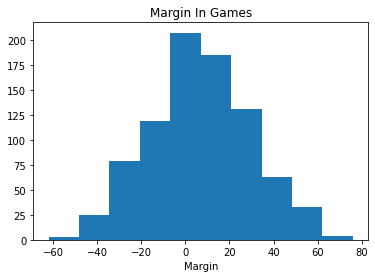

In [75]:
plt.hist(games2021['margin'])
plt.xlabel('Margin')
plt.title('Margin In Games')
plt.show()

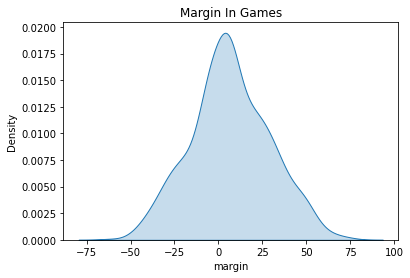

In [76]:
sns.kdeplot(games2021['margin'], shade=True)
plt.title('Margin In Games')
plt.show()

Separating the pregame elo rankings from the target variable of margin in order to begin to predict games.

In [77]:
games17_20 = pd.get_dummies(games2017_2020, columns=['home_conference', 'away_conference'])

In [78]:
games17_20.head()

,game_id,start_date,season,home_team,home_points,away_team,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,...,away_conference_American Athletic,away_conference_Big 12,away_conference_Big Ten,away_conference_Conference USA,away_conference_FBS Independents,away_conference_Mid-American,away_conference_Mountain West,away_conference_Pac-12,away_conference_SEC,away_conference_Sun Belt
0,400935282,2017-08-26T18:30:00.000Z,2017,Colorado State,58,Oregon State,27,1000,1000,1016,...,0,0,0,0,0,0,0,1,0,0
1,400945031,2017-08-26T19:00:00.000Z,2017,BYU,20,Portland State,6,1000,500,1000,...,0,0,0,0,0,0,0,0,0,0
2,400938887,2017-08-26T22:00:00.000Z,2017,UMass,35,Hawai'i,38,1000,1000,998,...,0,0,0,0,0,0,1,0,0,0
3,400941786,2017-08-26T23:30:00.000Z,2017,San José State,22,South Florida,42,1000,1000,990,...,1,0,0,0,0,0,0,0,0,0
4,400935257,2017-08-27T02:00:00.000Z,2017,Rice,7,Stanford,62,1000,1000,972,...,0,0,0,0,0,0,0,1,0,0


In [79]:
games17_20.columns

Index(['game_id', 'start_date', 'season', 'home_team', 'home_points',
       'away_team', 'away_points', 'pregame_home_elo', 'pregame_away_elo',
       'postgame_home_elo', 'postgame_away_elo', 'margin',
       'home_conference_ACC', 'home_conference_American Athletic',
       'home_conference_Big 12', 'home_conference_Big Ten',
       'home_conference_Conference USA', 'home_conference_FBS Independents',
       'home_conference_Mid-American', 'home_conference_Mountain West',
       'home_conference_Pac-12', 'home_conference_SEC',
       'home_conference_Sun Belt', 'away_conference_ACC',
       'away_conference_American Athletic', 'away_conference_Big 12',
       'away_conference_Big Ten', 'away_conference_Conference USA',
       'away_conference_FBS Independents', 'away_conference_Mid-American',
       'away_conference_Mountain West', 'away_conference_Pac-12',
       'away_conference_SEC', 'away_conference_Sun Belt'],
      dtype='object')

In [80]:
features = ['pregame_home_elo', 'pregame_away_elo', 'home_conference_ACC', 'home_conference_American Athletic',
       'home_conference_Big 12', 'home_conference_Big Ten',
       'home_conference_Conference USA', 'home_conference_FBS Independents',
       'home_conference_Mid-American', 'home_conference_Mountain West',
       'home_conference_Pac-12', 'home_conference_SEC',
       'home_conference_Sun Belt', 'away_conference_ACC',
       'away_conference_American Athletic', 'away_conference_Big 12',
       'away_conference_Big Ten', 'away_conference_Conference USA',
       'away_conference_FBS Independents', 'away_conference_Mid-American',
       'away_conference_Mountain West', 'away_conference_Pac-12',
       'away_conference_SEC', 'away_conference_Sun Belt']

x = games17_20[features]
y = games17_20['margin']

In [81]:
games21 = pd.get_dummies(games2021, columns=['home_conference', 'away_conference'])

In [82]:
x_test = games21[features]
y_test = games21['margin']

**Linear Regression**

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
lr = LinearRegression()

In [85]:
lr.fit(x,y)

LinearRegression()

In [86]:
y_pred = lr.predict(x_test)

In [87]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [88]:
# predicting the accuracy score
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.38262381370022713
mean_sqrd_error is  315.1952017173782
root_mean_squared error of is  17.75373768301701


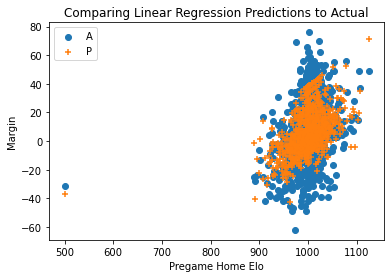

In [89]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing Linear Regression Predictions to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Margin')
plt.show()

**Linear Regression returns rather poor scores, will likely need to look into other modeling methods**

**Random Forest Regressor**

In [90]:
from sklearn.ensemble import RandomForestRegressor

In [91]:
forest = RandomForestRegressor(random_state=42)

In [92]:
forest.fit(x,y)

RandomForestRegressor(random_state=42)

In [93]:
y_pred = forest.predict(x_test)

In [94]:
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.2643281369083236
mean_sqrd_error is  375.5898695651807
root_mean_squared error of is  19.380141113139004


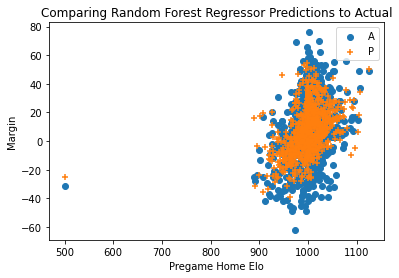

In [95]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing Random Forest Regressor Predictions to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Margin')
plt.show()

In [96]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [97]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

In [98]:
regr.fit(x,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [99]:
y_pred = regr.predict(x_test)

In [100]:
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.27964039040148214
mean_sqrd_error is  367.77235257047715
root_mean_squared error of is  19.17739170404769


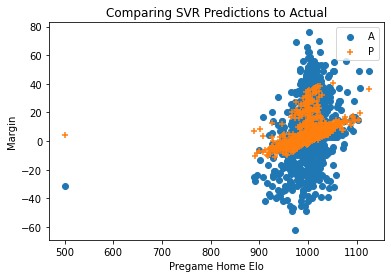

In [101]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing SVR Predictions to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Margin')
plt.show()

**Support Vector Regression**

In [102]:
features = ['pregame_home_elo', 'pregame_away_elo']

x = games2017_2020[features]
y = games2017_2020['margin']

x_test = games2021[features]
y_test = games2021['margin']

In [103]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

In [104]:
regr.fit(x,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [105]:
y_pred = regr.predict(x_test)

In [106]:
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.3319445619194592
mean_sqrd_error is  341.0689839305598
root_mean_squared error of is  18.468053062804422


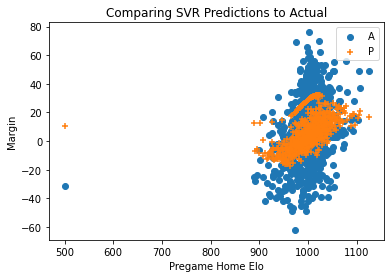

In [107]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing SVR Predictions to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Margin')
plt.show()

**Linear Regression**

In [108]:
lr = LinearRegression()

In [109]:
lr.fit(x,y)

LinearRegression()

In [110]:
y_pred = lr.predict(x_test)

In [111]:
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.2686092429933037
mean_sqrd_error is  373.4041939172159
root_mean_squared error of is  19.323669266400103


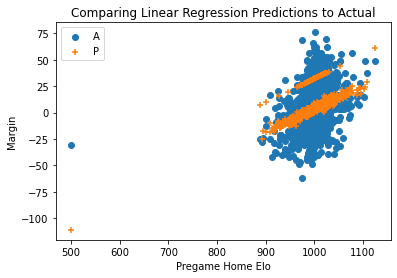

In [112]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing Linear Regression Predictions to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Margin')
plt.show()

In [113]:
from sklearn.ensemble import RandomForestRegressor

In [114]:
forest = RandomForestRegressor()

In [115]:
forest.fit(x,y)

RandomForestRegressor()

In [116]:
y_pred = forest.predict(x_test)

In [117]:
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.14986773402253628
mean_sqrd_error is  434.0264768993036
root_mean_squared error of is  20.83330211222656


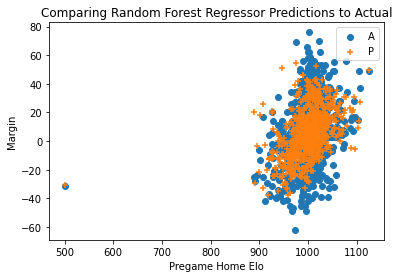

In [118]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing Random Forest Regressor Predictions to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Margin')
plt.show()

#### Summary

Overall it is rather difficult to guess the end of game margin accurately. The next step in this process would be trying to accurate predict who the winner is. Predicting the winner of a game would help tremendously with an accurate model predicting who wins.

In [119]:
HomeWin1 = games2017_2020[games2017_2020['margin'] > 0]

AwayWin1 = games2017_2020[games2017_2020['margin'] < 0]

In [120]:
HomeWin1.sample(5)

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin
462,401012765,2018-10-14T02:30:00.000Z,2018,USC,Pac-12,31,Colorado,Pac-12,20,996,1031,1002,1025,11
6,400937445,2017-08-31T22:30:00.000Z,2017,Wake Forest,ACC,51,Presbyterian College,None,7,1000,500,1001,499,44
587,401013341,2018-11-03T16:00:00.000Z,2018,Ohio State,Big Ten,36,Nebraska,Big Ten,31,1067,977,1069,975,5
601,401114189,2019-11-03T01:00:00.000Z,2019,UCLA,Pac-12,31,Colorado,Pac-12,14,984,972,992,964,17
597,401022552,2018-11-03T18:00:00.000Z,2018,Wyoming,Mountain West,24,San José State,Mountain West,9,970,952,977,945,15


In [121]:
AwayWin1.sample(5)

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin
51,401235996,2020-09-26T16:00:00.000Z,2020,Oklahoma,Big 12,35,Kansas State,Big 12,38,1001,998,999,1000,-3
704,401022560,2018-11-17T02:00:00.000Z,2018,New Mexico,Mountain West,14,Boise State,Mountain West,45,964,1057,954,1067,-31
677,401021702,2018-11-10T21:00:00.000Z,2018,Texas State,Sun Belt,7,Appalachian State,Sun Belt,38,975,1044,964,1055,-31
63,401014974,2018-09-01T23:00:00.000Z,2018,South Alabama,Sun Belt,26,Louisiana Tech,Conference USA,30,1000,1000,998,1002,-4
519,401249432,2020-12-13T03:00:00.000Z,2020,Oregon State,Pac-12,24,Stanford,Pac-12,27,993,992,991,994,-3


In [122]:
HomeWin1['Winner'] = 'H'
AwayWin1['Winner'] = 'A'

/Users/wrasmussen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/wrasmussen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [123]:
HomeWin1.head()

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin,Winner
0,400935282,2017-08-26T18:30:00.000Z,2017,Colorado State,Mountain West,58,Oregon State,Pac-12,27,1000,1000,1016,984,31,H
1,400945031,2017-08-26T19:00:00.000Z,2017,BYU,FBS Independents,20,Portland State,None,6,1000,500,1000,500,14,H
5,400938591,2017-08-31T22:00:00.000Z,2017,UCF,American Athletic,61,Florida International,Conference USA,17,1000,1000,1022,978,44,H
6,400937445,2017-08-31T22:30:00.000Z,2017,Wake Forest,ACC,51,Presbyterian College,None,7,1000,500,1001,499,44,H
8,400941787,2017-08-31T23:00:00.000Z,2017,Cincinnati,American Athletic,26,Austin Peay,None,14,1000,500,1000,500,12,H


In [124]:
frames = [HomeWin1, AwayWin1]

games20172020 = pd.concat(frames)

In [125]:
games20172020.sample(5)

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin,Winner
513,401022541,2018-10-20T23:30:00.000Z,2018,New Mexico,Mountain West,7,Fresno State,Mountain West,38,1006,1037,992,1051,-31,A
337,401215331,2020-11-14T20:30:00.000Z,2020,Georgia Southern,Sun Belt,40,Texas State,Sun Belt,38,1020,964,1021,963,2,H
810,400938669,2017-11-26T00:30:00.000Z,2017,Louisiana Tech,Conference USA,20,UT San Antonio,Conference USA,6,989,1018,997,1010,14,H
534,401013044,2018-10-27T16:00:00.000Z,2018,Iowa State,Big 12,40,Texas Tech,Big 12,31,1009,1026,1014,1021,9,H
731,401013064,2018-11-17T20:30:00.000Z,2018,Kansas State,Big 12,21,Texas Tech,Big 12,6,983,1016,991,1008,15,H


In [126]:
HomeWin2 = games2021[games2021['margin'] > 0]

AwayWin2 = games2021[games2021['margin'] < 0]

In [127]:
HomeWin2['Winner'] = 'H'
AwayWin2['Winner'] = 'A'

/Users/wrasmussen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/wrasmussen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [128]:
frames = [HomeWin2, AwayWin2]

games2021 = pd.concat(frames)

Now that we have created a column value for who won the game we can use a model that will predict whether the home team or away team will win a game.

**Logistic Regression of Winning Team**

In [129]:
from sklearn.linear_model import LogisticRegression

In [130]:
# minimal features

features = ['pregame_home_elo', 'pregame_away_elo']

x = games20172020[features]
y = games20172020['Winner']

x_test = games2021[features]
y_test = games2021['Winner']

In [131]:
log = LogisticRegression()

In [132]:
log.fit(x,y)

LogisticRegression()

In [133]:
y_pred = log.predict(x_test)

In [134]:
from sklearn.metrics import accuracy_score

In [135]:
score=accuracy_score(y_test,y_pred)
print('Accuracy score is ',score)

Accuracy score is  0.696113074204947


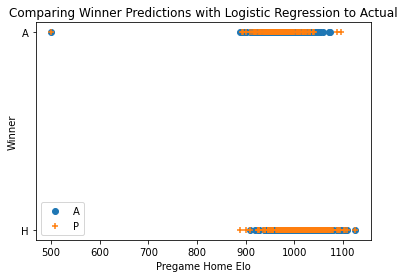

In [136]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing Winner Predictions with Logistic Regression to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Winner')
plt.show()

In [137]:
from sklearn.ensemble import RandomForestClassifier

In [138]:
forest = RandomForestClassifier(random_state=42)

In [139]:
forest.fit(x,y)

RandomForestClassifier(random_state=42)

In [140]:
y_pred = forest.predict(x_test)

In [141]:
score=accuracy_score(y_test,y_pred)
print('Accuracy score is ',score)

Accuracy score is  0.6855123674911661


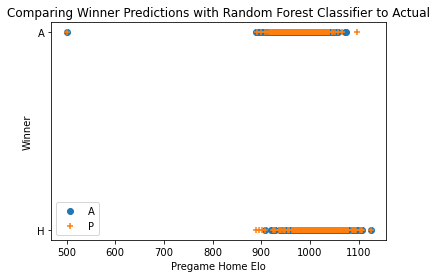

In [142]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing Winner Predictions with Random Forest Classifier to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Winner')
plt.show()

In [143]:
from sklearn.tree import DecisionTreeClassifier

In [144]:
tree = DecisionTreeClassifier(random_state=42)

In [145]:
tree.fit(x,y)

DecisionTreeClassifier(random_state=42)

In [146]:
y_pred = tree.predict(x_test)

In [147]:
score=accuracy_score(y_test,y_pred)
print('Accuracy score is ',score)

Accuracy score is  0.64075382803298


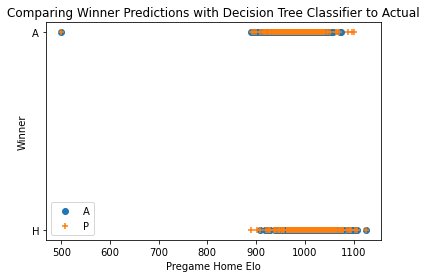

In [148]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing Winner Predictions with Decision Tree Classifier to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Winner')
plt.show()

In [149]:
games1720 = pd.get_dummies(games20172020, columns=['home_conference', 'away_conference'])

In [150]:
features = ['pregame_home_elo', 'pregame_away_elo', 'home_conference_ACC', 'home_conference_American Athletic',
       'home_conference_Big 12', 'home_conference_Big Ten',
       'home_conference_Conference USA', 'home_conference_FBS Independents',
       'home_conference_Mid-American', 'home_conference_Mountain West',
       'home_conference_Pac-12', 'home_conference_SEC',
       'home_conference_Sun Belt', 'away_conference_ACC',
       'away_conference_American Athletic', 'away_conference_Big 12',
       'away_conference_Big Ten', 'away_conference_Conference USA',
       'away_conference_FBS Independents', 'away_conference_Mid-American',
       'away_conference_Mountain West', 'away_conference_Pac-12',
       'away_conference_SEC', 'away_conference_Sun Belt']

x = games1720[features]
y = games1720['Winner']

In [151]:
games21 = pd.get_dummies(games2021, columns=['home_conference', 'away_conference'])

In [152]:
x_test = games21[features]
y_test = games21['Winner']

In [153]:
log = LogisticRegression()

In [154]:
log.fit(x,y)

LogisticRegression()

In [155]:
y_pred = log.predict(x_test)

In [156]:
score=accuracy_score(y_test,y_pred)
print('Accuracy score is ',score)

Accuracy score is  0.7078916372202592


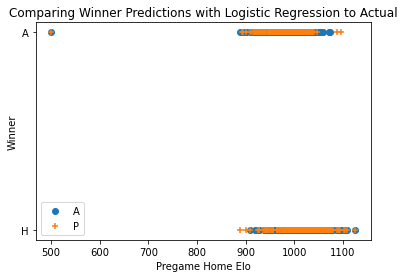

In [157]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing Winner Predictions with Logistic Regression to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Winner')
plt.show()

Adding in the conference really doesn't improve the accuracy enough and is bordering on overfitting.

In [158]:
from sklearn.ensemble import RandomForestClassifier

In [159]:
forest = RandomForestClassifier(random_state=42)

In [160]:
forest.fit(x,y)

RandomForestClassifier(random_state=42)

In [161]:
y_pred = forest.predict(x_test)

In [162]:
score=accuracy_score(y_test,y_pred)
print('Accuracy score is ',score)

Accuracy score is  0.6866902237926973


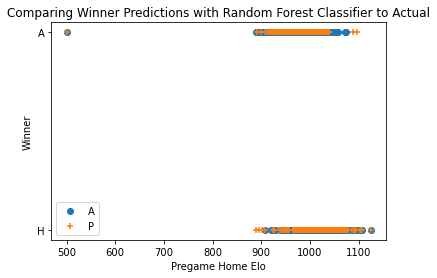

In [163]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing Winner Predictions with Random Forest Classifier to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Winner')
plt.show()

In [164]:
from sklearn.tree import DecisionTreeClassifier

In [165]:
tree = DecisionTreeClassifier(random_state=42)

In [166]:
tree.fit(x,y)

DecisionTreeClassifier(random_state=42)

In [167]:
y_pred = tree.predict(x_test)

In [168]:
score=accuracy_score(y_test,y_pred)
print('Accuracy score is ',score)

Accuracy score is  0.6395759717314488


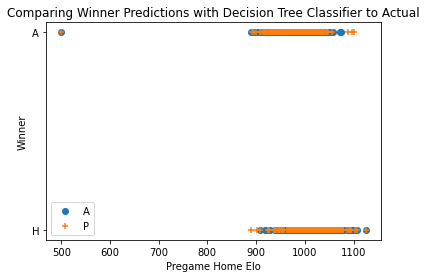

In [169]:
plt.scatter(x_test['pregame_home_elo'], y_test, marker='o')
plt.scatter(x_test['pregame_home_elo'], y_pred, marker='+')
plt.title('Comparing Winner Predictions with Decision Tree Classifier to Actual')
plt.legend(labels='AP')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Winner')
plt.show()

### A few more data visualizations

In [170]:
HomeWin1.head()

,game_id,start_date,season,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo,margin,Winner
0,400935282,2017-08-26T18:30:00.000Z,2017,Colorado State,Mountain West,58,Oregon State,Pac-12,27,1000,1000,1016,984,31,H
1,400945031,2017-08-26T19:00:00.000Z,2017,BYU,FBS Independents,20,Portland State,None,6,1000,500,1000,500,14,H
5,400938591,2017-08-31T22:00:00.000Z,2017,UCF,American Athletic,61,Florida International,Conference USA,17,1000,1000,1022,978,44,H
6,400937445,2017-08-31T22:30:00.000Z,2017,Wake Forest,ACC,51,Presbyterian College,None,7,1000,500,1001,499,44,H
8,400941787,2017-08-31T23:00:00.000Z,2017,Cincinnati,American Athletic,26,Austin Peay,None,14,1000,500,1000,500,12,H


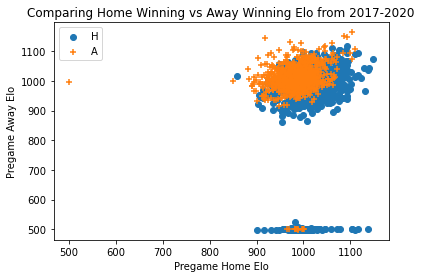

In [171]:
plt.scatter(HomeWin1['pregame_home_elo'], HomeWin1['pregame_away_elo'], marker='o')
plt.scatter(AwayWin1['pregame_home_elo'], AwayWin1['pregame_away_elo'], marker='+')
plt.legend(labels='HA')
plt.title('Comparing Home Winning vs Away Winning Elo from 2017-2020')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Pregame Away Elo')
plt.show()

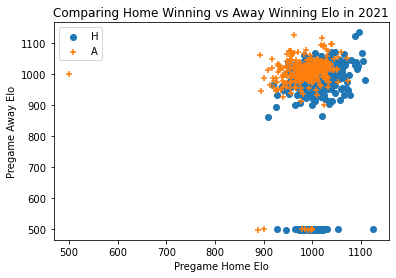

In [172]:
plt.scatter(HomeWin2['pregame_home_elo'], HomeWin2['pregame_away_elo'], marker='o')
plt.scatter(AwayWin2['pregame_home_elo'], AwayWin2['pregame_away_elo'], marker='+')
plt.legend(labels='HA')
plt.title('Comparing Home Winning vs Away Winning Elo in 2021')
plt.xlabel('Pregame Home Elo')
plt.ylabel('Pregame Away Elo')
plt.show()

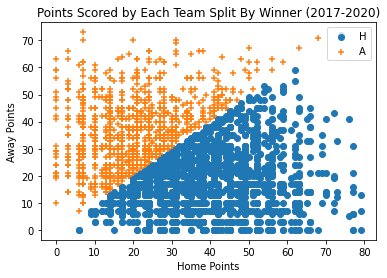

In [173]:
plt.scatter(HomeWin1['home_points'], HomeWin1['away_points'], marker='o')
plt.scatter(AwayWin1['home_points'], AwayWin1['away_points'], marker='+')
plt.legend(labels='HA')
plt.title('Points Scored by Each Team Split By Winner (2017-2020)')
plt.xlabel('Home Points')
plt.ylabel('Away Points')
plt.show()

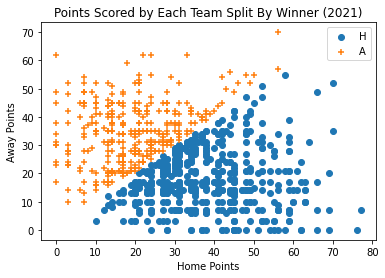

In [174]:
plt.scatter(HomeWin2['home_points'], HomeWin2['away_points'], marker='o')
plt.scatter(AwayWin2['home_points'], AwayWin2['away_points'], marker='+')
plt.legend(labels='HA')
plt.title('Points Scored by Each Team Split By Winner (2021)')
plt.xlabel('Home Points')
plt.ylabel('Away Points')
plt.show()

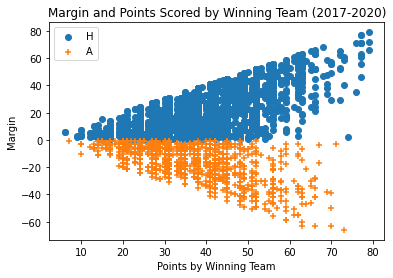

In [175]:
plt.scatter(HomeWin1['home_points'], HomeWin1['margin'], marker='o')
plt.scatter(AwayWin1['away_points'], AwayWin1['margin'], marker='+')
plt.legend(labels='HA')
plt.title('Margin and Points Scored by Winning Team (2017-2020)')
plt.xlabel('Points by Winning Team')
plt.ylabel('Margin')
plt.show()

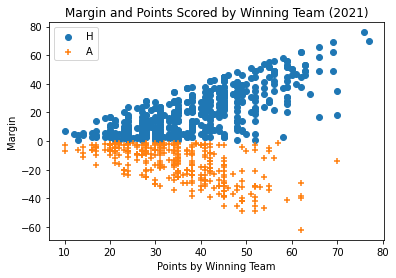

In [176]:
plt.scatter(HomeWin2['home_points'], HomeWin2['margin'], marker='o')
plt.scatter(AwayWin2['away_points'], AwayWin2['margin'], marker='+')
plt.legend(labels='HA')
plt.title('Margin and Points Scored by Winning Team (2021)')
plt.xlabel('Points by Winning Team')
plt.ylabel('Margin')
plt.show()

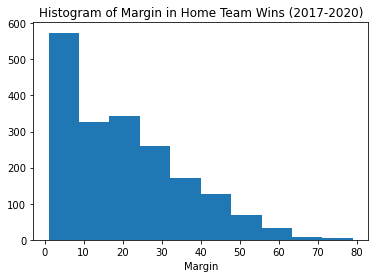

In [177]:
plt.hist(HomeWin1['margin'])
plt.title('Histogram of Margin in Home Team Wins (2017-2020)')
plt.xlabel('Margin')
plt.show()

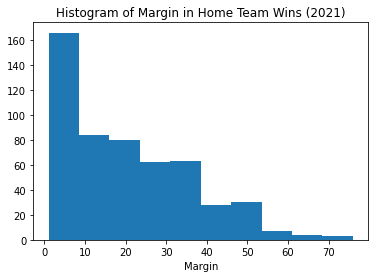

In [178]:
plt.hist(HomeWin2['margin'])
plt.title('Histogram of Margin in Home Team Wins (2021)')
plt.xlabel('Margin')
plt.show()

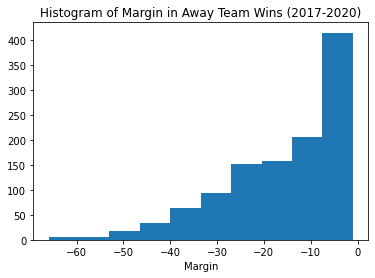

In [179]:
plt.hist(AwayWin1['margin'])
plt.title('Histogram of Margin in Away Team Wins (2017-2020)')
plt.xlabel('Margin')
plt.show()

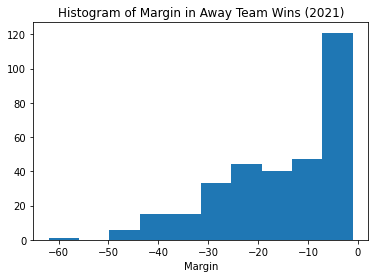

In [180]:
plt.hist(AwayWin2['margin'])
plt.title('Histogram of Margin in Away Team Wins (2021)')
plt.xlabel('Margin')
plt.show()

In [181]:
import seaborn as sns

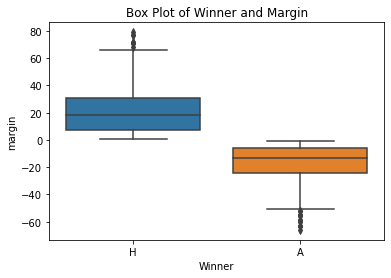

In [182]:
sns.boxplot(x=games1720['Winner'], y=games1720['margin'])
plt.title('Box Plot of Winner and Margin')
plt.show()

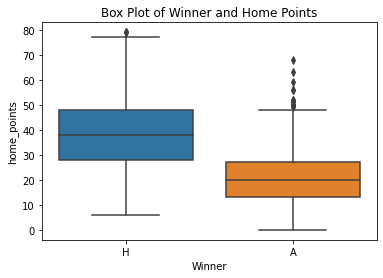

In [183]:
sns.boxplot(x=games1720['Winner'], y=games1720['home_points'])
plt.title('Box Plot of Winner and Home Points')
plt.show()

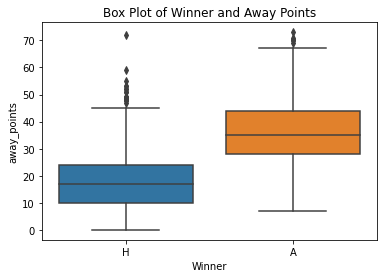

In [184]:
sns.boxplot(x=games1720['Winner'], y=games1720['away_points'])
plt.title('Box Plot of Winner and Away Points')
plt.show()

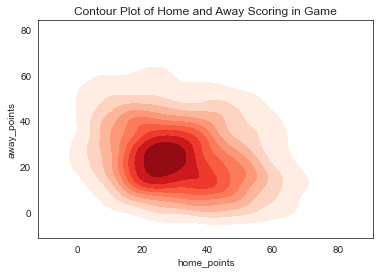

In [185]:
sns.set_style('white')

sns.kdeplot(x=games1720['home_points'], y=games1720['away_points'], cmap='Reds', shade=True)
plt.title('Contour Plot of Home and Away Scoring in Game')
plt.show()